In [21]:
import os
import json
import matplotlib.pyplot as plt
import seaborn as sns
import pprint
import warnings
import numpy as np
import pandas as pd

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from joblib import Parallel, delayed
from tqdm import tqdm, tqdm_notebook
from sklearn.model_selection import GridSearchCV
import os
from sklearn.model_selection import StratifiedKFold


# part 2
# required packages
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.svm import SVC

from textblob import TextBlob
import numpy as np # linear algebra
import pandas as pd
pd.set_option('display.max_rows', None)  # Display all rows
pd.set_option('display.max_columns', None)  # Display all columns
import json
import cv2
import skimage.feature as skf
import skimage.filters as skg
from skimage.measure import shannon_entropy
from scipy.stats import entropy
from sklearn.cluster import KMeans

from sklearn.model_selection import learning_curve
from sklearn.metrics import log_loss

%matplotlib inline

np.random.seed(seed=555)
warnings.filterwarnings('ignore')



In [3]:

# Load data
train = pd.read_csv('input/train/train.csv')
test = pd.read_csv('input/test/test.csv')
breed_labels = pd.read_csv('input/breed_labels.csv')
color_labels = pd.read_csv('input/color_labels.csv')
state_labels = pd.read_csv('input/state_labels.csv')


In [4]:
train.head()

,Type,Name,Age,Breed1,Breed2,Gender,Color1,Color2,Color3,MaturitySize,FurLength,Vaccinated,Dewormed,Sterilized,Health,Quantity,Fee,State,RescuerID,VideoAmt,Description,PetID,PhotoAmt,AdoptionSpeed
0,2,Nibble,3,299,0,1,1,7,0,1,1,2,2,2,1,1,100,41326,8480853f516546f6cf33aa88cd76c379,0,Nibble is a 3+ month old ball of cuteness. He ...,86e1089a3,1.0,2
1,2,No Name Yet,1,265,0,1,1,2,0,2,2,3,3,3,1,1,0,41401,3082c7125d8fb66f7dd4bff4192c8b14,0,I just found it alone yesterday near my apartm...,6296e909a,2.0,0
2,1,Brisco,1,307,0,1,2,7,0,2,2,1,1,2,1,1,0,41326,fa90fa5b1ee11c86938398b60abc32cb,0,Their pregnant mother was dumped by her irresp...,3422e4906,7.0,3
3,1,Miko,4,307,0,2,1,2,0,2,1,1,1,2,1,1,150,41401,9238e4f44c71a75282e62f7136c6b240,0,"Good guard dog, very alert, active, obedience ...",5842f1ff5,8.0,2
4,1,Hunter,1,307,0,1,1,0,0,2,1,2,2,2,1,1,0,41326,95481e953f8aed9ec3d16fc4509537e8,0,This handsome yet cute boy is up for adoption....,850a43f90,3.0,2


In [5]:
# Display basic information about the data
train.info()

# Check for missing values
train.isnull().sum()

# Descriptive statistics
train.describe()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14993 entries, 0 to 14992
Data columns (total 24 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Type           14993 non-null  int64  
 1   Name           13728 non-null  object 
 2   Age            14993 non-null  int64  
 3   Breed1         14993 non-null  int64  
 4   Breed2         14993 non-null  int64  
 5   Gender         14993 non-null  int64  
 6   Color1         14993 non-null  int64  
 7   Color2         14993 non-null  int64  
 8   Color3         14993 non-null  int64  
 9   MaturitySize   14993 non-null  int64  
 10  FurLength      14993 non-null  int64  
 11  Vaccinated     14993 non-null  int64  
 12  Dewormed       14993 non-null  int64  
 13  Sterilized     14993 non-null  int64  
 14  Health         14993 non-null  int64  
 15  Quantity       14993 non-null  int64  
 16  Fee            14993 non-null  int64  
 17  State          14993 non-null  int64  
 18  Rescue

,Type,Age,Breed1,Breed2,Gender,Color1,Color2,Color3,MaturitySize,FurLength,Vaccinated,Dewormed,Sterilized,Health,Quantity,Fee,State,VideoAmt,PhotoAmt,AdoptionSpeed
count,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000
mean,1.457614,10.452078,265.272594,74.009738,1.776162,2.234176,3.222837,1.882012,1.862002,1.467485,1.731208,1.558727,1.914227,1.036617,1.576069,21.259988,41346.028347,0.056760,3.889215,2.516441
std,0.498217,18.155790,60.056818,123.011575,0.681592,1.745225,2.742562,2.984086,0.547959,0.599070,0.667649,0.695817,0.566172,0.199535,1.472477,78.414548,32.444153,0.346185,3.487810,1.177265
min,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,41324.000000,0.000000,0.000000,0.000000
25%,1.000000,2.000000,265.000000,0.000000,1.000000,1.000000,0.000000,0.000000,2.000000,1.000000,1.000000,1.000000,2.000000,1.000000,1.000000,0.000000,41326.000000,0.000000,2.000000,2.000000
50%,1.000000,3.000000,266.000000,0.000000,2.000000,2.000000,2.000000,0.000000,2.000000,1.000000,2.000000,1.000000,2.000000,1.000000,1.000000,0.000000,41326.000000,0.000000,3.000000,2.000000
75%,2.000000,12.000000,307.000000,179.000000,2.000000,3.000000,6.000000,5.000000,2.000000,2.000000,2.000000,2.000000,2.000000,1.000000,1.000000,0.000000,41401.000000,0.000000,5.000000,4.000000
max,2.000000,255.000000,307.000000,307.000000,3.000000,7.000000,7.000000,7.000000,4.000000,3.000000,3.000000,3.000000,3.000000,3.000000,20.000000,3000.000000,41415.000000,8.000000,30.000000,4.000000


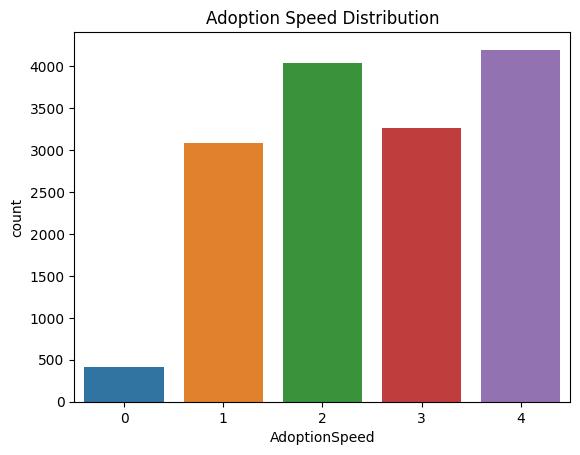

In [6]:
# Visualize AdoptionSpeed distribution
sns.countplot(x='AdoptionSpeed', data=train)
plt.title('Adoption Speed Distribution')
plt.show()

## Age

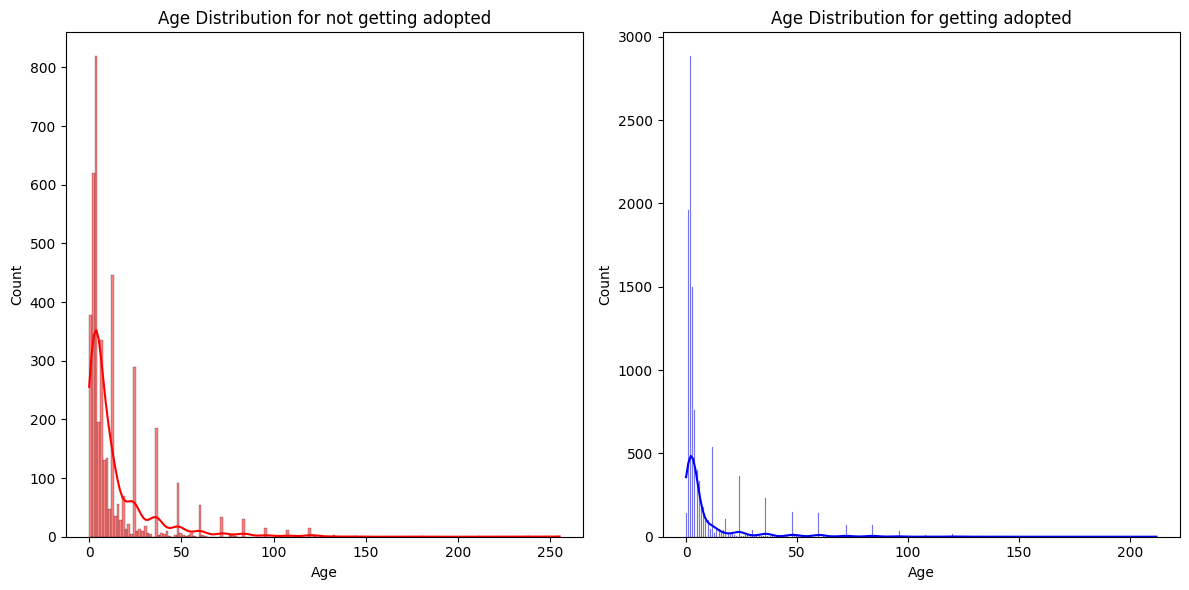

In [7]:
data = train.copy()

data_4 = data[data['AdoptionSpeed']==4]
data_rest = data[data['AdoptionSpeed']<4]
# Create subplots
plt.figure(figsize=(12, 6))
# Plot age distribution for fraud cases
plt.subplot(1, 2, 1)
sns.histplot(data=data_4, x='Age', kde=True, color='red')
plt.title("Age Distribution for not getting adopted")

# Plot age distribution for non-fraud cases
plt.subplot(1, 2, 2)
sns.histplot(data=data_rest, x='Age', kde=True, color='blue')
plt.title("Age Distribution for getting adopted")

# Show the plots
plt.tight_layout()
plt.show()

In [22]:
# checking age where month is greater than 100. 
np.where(train['Age']>100)

(array([  113,   145,   513,  1057,  1141,  1363,  1703,  1858,  1867,
         2263,  2497,  2767,  2830,  3195,  3684,  3931,  3998,  4071,
         4344,  4456,  4522,  4617,  4796,  5007,  5067,  5160,  5485,
         5535,  5569,  5593,  6264,  6569,  6618,  6666,  6722,  6894,
         6992,  7166,  7250,  7289,  7482,  7512,  7614,  7823,  8058,
         8065,  8304,  8492,  8944,  9267,  9378,  9563,  9970, 10089,
        10128, 10337, 10426, 10501, 10658, 10737, 10917, 11087, 11172,
        11216, 11314, 11523, 11605, 11640, 11968, 12526, 12575, 12621,
        12737, 12855, 12947, 13079, 13398, 13493, 13665, 13744, 14189,
        14303, 14637, 14732], dtype=int64),)

In [36]:
def age_segment(df):

    # Creating the "age_group" column by binning them into 4 groups
    conditions = [
        df['Age'] < 20,
        (df['Age'] >= 20) & (df['Age'] <= 40),
        (df['Age'] >= 40) & (df['Age'] <= 60),
        (df['Age'] >= 60) & (df['Age'] <= 80),
        (df['Age'] >= 80) & (df['Age'] <= 100)
    ]
    choices = ['1-20', '20-40', '40-60', '60-80','80-100']
    df['AgeGroup'] = np.select(conditions, choices, default='Unknown')
    
    return df


In [5]:
def extract_texture_features(image_path):
    # Load the image
    img = cv2.imread(image_path)

    # Convert the image to grayscale
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    haralick = skf.graycomatrix(img_gray, [1], [0], 256, symmetric=True, normed=True) 
    energy = skf.graycoprops(haralick, 'energy')[0, 0] 
    contrast = skf.graycoprops(haralick, 'contrast')[0, 0] 
    correlation = skf.graycoprops(haralick, 'correlation')[0, 0] 
    entropy = shannon_entropy(img_gray)

    mean = np.mean(img)
    std_dev = np.std(img)

    return energy, contrast, correlation, entropy, mean, std_dev


In [97]:
def extract_keypoints(file_path):
    # Load an image
    image = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)

    # Initialize the SIFT detector
    sift = cv2.SIFT_create()

    # Detect and compute SIFT keypoints and descriptors
    keypoints, _ = sift.detectAndCompute(image, None)

    # Return the number of keypoints
    return len(keypoints)


df_train_img['num_checkpoints'] = None  # Initialize the column

def extract_and_update(row):
    file_path = os.path.join(train_img_path, f"{row['PetID']}.jpg")
    num_keypoints = extract_keypoints(file_path)
    return num_keypoints


# Update the 'num_checkpoints' column
df_train_img['num_checkpoints'] = df_train_img.apply(extract_and_update, axis=1)
# df_train_img.to_csv('train_img_keypoints.csv')



In [98]:
# Columns to drop
columns_to_drop = ['mean_h', 'mean_s', 'mean_v', 'variance_h', 'variance_s', 'variance_v', 'Unnamed: 0']

# Drop specified columns
final_keypoints = df_train_img.drop(columns=columns_to_drop, errors='ignore')

# Print the resulting DataFrame
final_keypoints.head()


,PetID,Energy,Contrast,Correlation,Entropy,Mean,Std_Dev,num_checkpoints
0,0008c5398-1,0.024081,78.820303,0.989859,7.601080,143.223922,70.638848,319
0,0008c5398-2,0.070913,41.355089,0.994805,7.284530,91.658592,64.059420,233
0,0008c5398-3,0.040957,66.469614,0.989986,7.594550,111.068160,73.856578,410
0,0008c5398-4,0.050778,150.613044,0.984973,7.517500,108.980235,71.533391,469
0,0008c5398-5,0.025575,79.317245,0.992683,7.719211,141.169160,76.906123,395


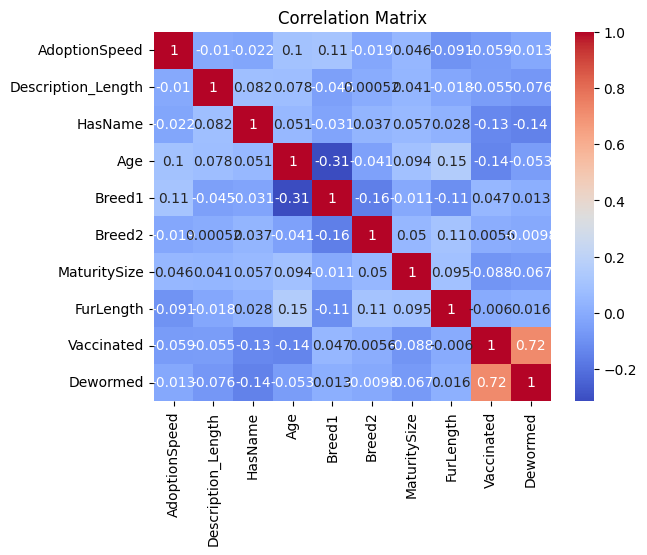

In [269]:
cols = ['AdoptionSpeed','Description_Length','HasName','Age', 'Breed1', 'Breed2', 'MaturitySize', 'FurLength', 'Vaccinated',
       'Dewormed', 'Sterilized', 'Health', 'Quantity', 'Fee', 'State',
       'VideoAmt', 'PhotoAmt', 'Description_Length', 'HasName', 'Type_1',
       'Type_2', 'Gender_1', 'Gender_2', 'Gender_3']
corr_df = train[cols[:10]]
# # Explore correlations
correlation_matrix = corr_df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

In [108]:
# checking our new features
train.head()

,Type,Name,Age,Breed1,Breed2,Gender,Color1,Color2,Color3,MaturitySize,FurLength,Vaccinated,Dewormed,Sterilized,Health,Quantity,Fee,State,RescuerID,VideoAmt,Description,PetID,PhotoAmt,AdoptionSpeed,Description_Length,HasName,polarity,subjectivity
0,2,Nibble,3,299,0,1,1,7,0,1,1,2,2,2,1,1,100,41326,8480853f516546f6cf33aa88cd76c379,0,Nibble is a 3+ month old ball of cuteness. He ...,86e1089a3,1.0,2,359,1,0.130357,0.407143
1,2,No Name Yet,1,265,0,1,1,2,0,2,2,3,3,3,1,1,0,41401,3082c7125d8fb66f7dd4bff4192c8b14,0,I just found it alone yesterday near my apartm...,6296e909a,2.0,0,118,1,0.100000,0.400000
2,1,Brisco,1,307,0,1,2,7,0,2,2,1,1,2,1,1,0,41326,fa90fa5b1ee11c86938398b60abc32cb,0,Their pregnant mother was dumped by her irresp...,3422e4906,7.0,3,393,1,0.261905,0.542857
3,1,Miko,4,307,0,2,1,2,0,2,1,1,1,2,1,1,150,41401,9238e4f44c71a75282e62f7136c6b240,0,"Good guard dog, very alert, active, obedience ...",5842f1ff5,8.0,2,146,1,0.341146,0.437500
4,1,Hunter,1,307,0,1,1,0,0,2,1,2,2,2,1,1,0,41326,95481e953f8aed9ec3d16fc4509537e8,0,This handsome yet cute boy is up for adoption....,850a43f90,3.0,2,390,1,0.400000,0.743750


# F V 2.5

In [32]:
# Load data
train = pd.read_csv('input/train/train.csv')
test = pd.read_csv('input/test/test.csv')
breed_labels = pd.read_csv('input/breed_labels.csv')
color_labels = pd.read_csv('input/color_labels.csv')
state_labels = pd.read_csv('input/state_labels.csv')
df_image = pd.read_csv("image_features.csv", header = 0)

def get_polarity(text):
    return TextBlob(text).sentiment.polarity

def get_subjectivity(text):
    return TextBlob(text).sentiment.subjectivity

def get_features(train):
    # Creating a new feature based on the length of the description
    train['Description_Length'] = train['Description'].apply(lambda x: len(str(x)))
    # Creating a feature indicating whether a pet has a name or not
    train['HasName'] = train['Name'].apply(lambda x: 0 if pd.isnull(x) else 1)


    train['Polarity'] = train['Description'].astype(str).apply(get_polarity)
    train['Subjectivity'] = train['Description'].astype(str).apply(get_subjectivity)

    # Adding features engineering for train dataset
    to_scale = ['AgeScaled']
    scale_num = ['Age']
    train[to_scale] = (train[scale_num] - train[scale_num].mean()) / train[scale_num].std()

    # Concatenating Breed1, Age and Furlength features
    train['Breed1AgeFurLength'] = (train['Breed1'].astype(str) + np.abs(train['AgeScaled']).astype(str) + train['FurLength'].astype(str)).astype(float)
    train['Breed2AgeFurLength'] = (train['Breed2'].astype(str) + np.abs(train['AgeScaled']).astype(str) + train['FurLength'].astype(str)).astype(float)

    # Concatenating binary features such as Vaccinated, Dewormed and Sterilized
    train['VDSCombination'] = (train['Vaccinated'].astype(str) + train['Dewormed'].astype(str) + train['Sterilized'].astype(str)).astype(float)

    # Creating a color count feature without including cases where any color is 0
    train['ColorCount'] = train[['Color1', 'Color2', 'Color3']].apply(lambda row: len([color for color in row if color != 0]), axis=1)

    # Creating a total visual media feature
    train['TotalVisualMedia'] = train['PhotoAmt'] + train['VideoAmt']

    # Creating a description length feature
    train['DescriptionLength'] = train['Description'].apply(lambda x: len(str(x)))

    # Creating a sentiment score feature
    train['SentimentScore'] = train['Description'].apply(lambda x: TextBlob(str(x)).sentiment.polarity)
    
    #Name_word_len, 'RescuerID_3', 'RescuerID_5', 'Description_len', 'PhotoAmt', 'Name_word_len', 'is_emoji'
    train['Name_word_len'] = train['Name'].fillna('').apply(lambda x : len(x.split(' ')))

    to_drop = ['AgeScaled']
    train = train.drop(to_drop, axis = 1)
    
    # Adding image features to dataset

    # First finding the position of '-' in PetID
    df_image['pos'] = df_image['PetID'].str.find('-')
    df_image.drop(columns=['Unnamed: 0'], axis=1, inplace=True)

    # Using position to slice PetID using a lambda function
    df_image['PetID'] = df_image.apply(lambda x: x['PetID'][0:x['pos']],axis=1)
    
    df_image.drop(columns=['pos'], axis=1, inplace=True)

    train = pd.merge(train, df_image, how="inner", on=["PetID"], copy=True)

    return train
train = get_features(train)

In [24]:
train.shape

(58311, 42)

In [62]:
train.columns

Index(['Type', 'Name', 'Age', 'Breed1', 'Breed2', 'Gender', 'Color1', 'Color2',
       'Color3', 'MaturitySize', 'FurLength', 'Vaccinated', 'Dewormed',
       'Sterilized', 'Health', 'Quantity', 'Fee', 'State', 'RescuerID',
       'VideoAmt', 'Description', 'PetID', 'PhotoAmt', 'AdoptionSpeed',
       'Description_Length', 'HasName', 'Subjectivity', 'Breed1AgeFurLength',
       'Breed2AgeFurLength', 'VDSCombination', 'ColorCount',
       'TotalVisualMedia', 'DescriptionLength', 'SentimentScore',
       'Name_word_len', 'Energy', 'Contrast', 'Correlation', 'Entropy', 'Mean',
       'Std_Dev', 'num_checkpoints'],
      dtype='object')

In [45]:
train.columns

Index(['Type', 'Name', 'Age', 'Breed1', 'Breed2', 'Gender', 'Color1', 'Color2',
       'Color3', 'MaturitySize', 'FurLength', 'Vaccinated', 'Dewormed',
       'Sterilized', 'Health', 'Quantity', 'Fee', 'State', 'RescuerID',
       'VideoAmt', 'Description', 'PetID', 'PhotoAmt', 'AdoptionSpeed',
       'Description_Length', 'HasName', 'Subjectivity', 'Breed1AgeFurLength',
       'Breed2AgeFurLength', 'VDSCombination', 'ColorCount',
       'TotalVisualMedia', 'DescriptionLength', 'SentimentScore',
       'Name_word_len', 'Energy', 'Contrast', 'Correlation', 'Entropy', 'Mean',
       'Std_Dev', 'num_checkpoints'],
      dtype='object')


## With Encoding

In [25]:
def rf_we(train):
    numeric_features = ['Age','Fee','VideoAmt','PhotoAmt','Quantity']

    categorical_features = ['Type', 'Color1', 'Color2', 'Gender', 'MaturitySize', 
                        'FurLength', 'Vaccinated', 'Sterilized', 'Health', 'Breed1','Gender']

    numeric_transformer = Pipeline(steps=[
        ('scaler', StandardScaler())])


    categorical_transformer = Pipeline(steps=[

        ('onehot', OneHotEncoder(handle_unknown='ignore'))])

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)])


    cols_to_drop = ['PetID', 'AdoptionSpeed','Description','Name','RescuerID']
    X = train.drop(cols_to_drop, axis=1)
    y = train['AdoptionSpeed']
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)


    model_1 = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', 
                       RandomForestClassifier(n_jobs=-1, n_estimators=200)
                         )])  
    model_1.fit(X_train,y_train)

    # make predictions on test data
    y_model_randomforest = model_1.predict(X_valid)

    # accuracy score
    train_accuracy_rf = model_1.score(X_train, y_train)
    test_accuracy_rf = model_1.score(X_valid, y_valid)
    print("Random Forest train accuracy: {:.2f}%".format(train_accuracy_rf * 100))
    print("Random Forest test accuracy: {:.2f}%".format(test_accuracy_rf * 100))
    return model_1

In [26]:

rf_we(train)

Random Forest train accuracy: 96.60%
Random Forest test accuracy: 90.65%


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['Age', 'Fee', 'VideoAmt',
                                                   'PhotoAmt', 'Quantity']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Type', 'Color1', 'Color2',
                                                   'Gender', 'MaturitySize',
                                                   'FurLength', 'Vaccinated',
                                                   'Sterilized', 'Health',
                                                   'Breed1', 'Gender'])])),
                ('classifier',
                 RandomForestClassifier(n_estimators=200, n_jobs=-1))])

In [ ]:
# Since we have Class Imbalances lets use stratifiedkfold to evaluate

In [34]:


def rf_with_stratified_kfold(train, n_splits=5):
    numeric_features = ['Age','Fee','VideoAmt','PhotoAmt','Quantity']
    categorical_features = ['Type', 'Color1', 'Color2', 'Gender', 'MaturitySize', 
                            'FurLength', 'Vaccinated', 'Sterilized', 'Health', 'Breed1','Gender']

    numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])
    categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)])

    cols_to_drop = ['PetID', 'AdoptionSpeed','Description','Name','RescuerID']
    X = train.drop(cols_to_drop, axis=1)
    y = train['AdoptionSpeed']

    # Initialize StratifiedKFold
    stratified_kfold = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

    # Lists to store accuracy scores for each fold
    train_accuracies = []
    test_accuracies = []

    for train_index, test_index in stratified_kfold.split(X, y):
        X_train, X_valid = X.iloc[train_index], X.iloc[test_index]
        y_train, y_valid = y.iloc[train_index], y.iloc[test_index]

        model = Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('classifier', RandomForestClassifier(n_jobs=-1, n_estimators=200))
        ])

        model.fit(X_train, y_train)

        # Making predictions on validation data
        y_model_randomforest = model.predict(X_valid)

        # Accuracy scores
        train_accuracy_rf = model.score(X_train, y_train)
        test_accuracy_rf = model.score(X_valid, y_valid)

        print("Random Forest train accuracy: {:.2f}%".format(train_accuracy_rf * 100))
        print("Random Forest test accuracy: {:.2f}%".format(test_accuracy_rf * 100))

        train_accuracies.append(train_accuracy_rf)
        test_accuracies.append(test_accuracy_rf)

    print("\nAverage Random Forest train accuracy: {:.2f}%".format(sum(train_accuracies) / n_splits * 100))
    print("Average Random Forest test accuracy: {:.2f}%".format(sum(test_accuracies) / n_splits * 100))

    return model

model_with_stratified_kfold = rf_with_stratified_kfold(train, n_splits=5)


Random Forest train accuracy: 96.54%
Random Forest test accuracy: 91.12%
Random Forest train accuracy: 96.54%
Random Forest test accuracy: 91.35%
Random Forest train accuracy: 96.59%
Random Forest test accuracy: 90.88%
Random Forest train accuracy: 96.53%
Random Forest test accuracy: 91.09%
Random Forest train accuracy: 96.60%
Random Forest test accuracy: 90.82%

Average Random Forest train accuracy: 96.56%
Average Random Forest test accuracy: 91.05%


## GridSearch CV

In [13]:
def gscv_we(train):   
    cols_to_drop = ['PetID', 'AdoptionSpeed','Description','Name','RescuerID']
    X = train.drop(cols_to_drop, axis=1)
    y = train['AdoptionSpeed']
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

    numerical_columns = train.select_dtypes(include=['number']).drop(['AdoptionSpeed'],axis = 1)
    numeric_features = list(numerical_columns.columns)
    categorical_features = ['Type', 'Color1', 'Color2', 'Gender', 'MaturitySize', 
                        'FurLength', 'Vaccinated', 'Sterilized', 'Health', 'Breed1','Gender']

    numeric_transformer = Pipeline(steps=[
        ('scaler', StandardScaler())])


    categorical_transformer = Pipeline(steps=[

        ('onehot', OneHotEncoder(handle_unknown='ignore'))])

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)])

    # Fitting the preprocessor on the training data
    preprocessor.fit(X_train)

    # pipeline for preprocessor and randomforest
    pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', 
                       RandomForestClassifier()
                         )])  



    # # Create the parameter grid based on the results of random search 
    param_grid = {
        'classifier__bootstrap': [True],  # Method of selecting samples for training each tree
        'classifier__max_depth': [120, 140, 150, 160],  # Maximum number of levels in tree
        'classifier__min_samples_leaf': [3, 4, 5],  # Minimum number of samples required at each leaf node
        'classifier__min_samples_split': [8, 10, 12],  # Minimum number of samples required to split a node
        'classifier__n_estimators': [100, 200, 300]  # Number of trees in random forest
    }

 


    # Instantiate the grid search model
    grid = GridSearchCV(estimator = pipeline, param_grid = param_grid, 
                              cv = 3, n_jobs = -1, verbose = 2)#scoring='accuracy'
    grid.fit(X_train, y_train);
    
    print(grid.best_params_)

    model = grid.best_estimator_
    y_model = model.predict(X_valid)
    y_model_train = model.predict(X_train)

    # accuracy score
    train_accuracy_rf = model.score(X_train, y_train)
    test_accuracy_rf = model.score(X_valid, y_valid)
    print("Random Forest train accuracy: {:.2f}%".format(train_accuracy_rf * 100))
    print("Random Forest test accuracy: {:.2f}%".format(test_accuracy_rf * 100))
    
    return model


In [41]:
%%time gscv_we(train) # fv2.5

Fitting 3 folds for each of 108 candidates, totalling 324 fits
Random Forest train accuracy: 98.52%
Random Forest test accuracy: 88.65%


In [ ]:
model = gscv_we(train)

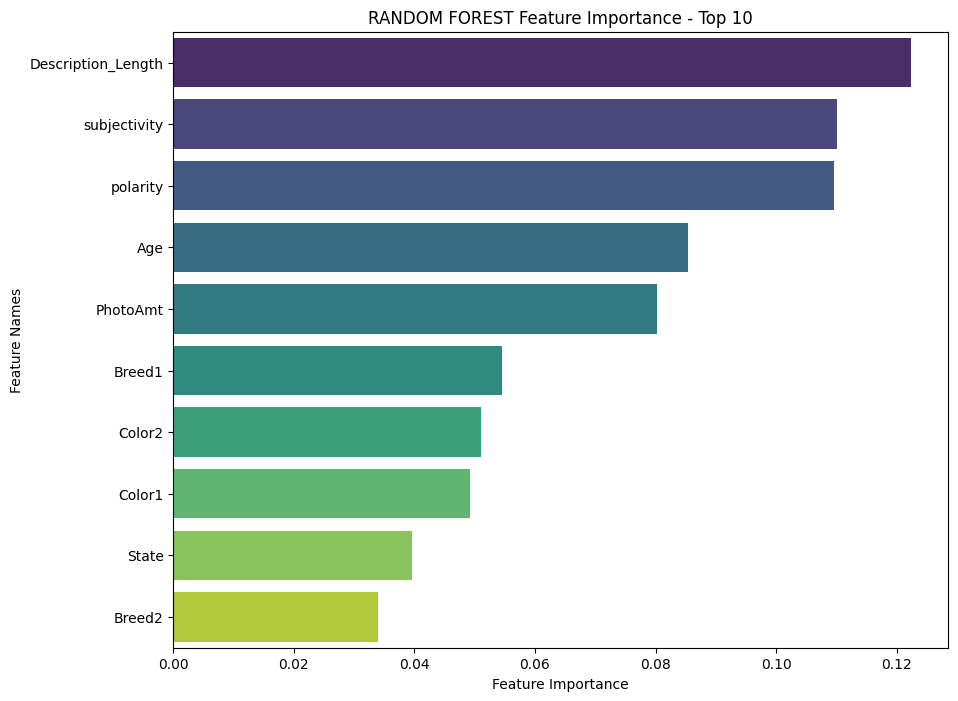

In [38]:
columns = X.columns
plot_feature_importance(model.feature_importances_,columns[:],'RANDOM FOREST',10)


Random Forest train accuracy: 96.60%
Random Forest test accuracy: 90.51%


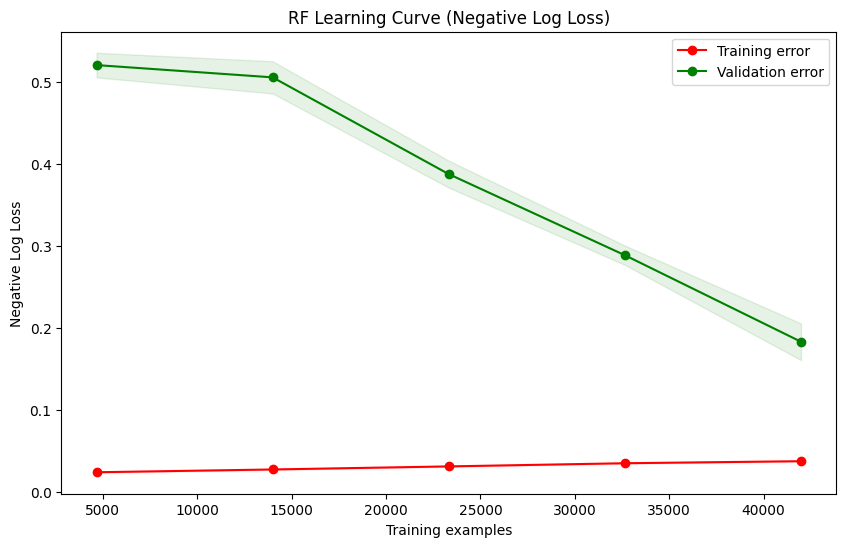

In [37]:


def plot_learning_curve_errors(model, X, y, title="Learning Curve"):
    train_sizes, train_errors, test_errors = learning_curve(
        model, X, y, cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
        train_sizes=[0.1, 0.3, 0.5, 0.7, 0.9], scoring='neg_log_loss', n_jobs=-1
    )

    train_errors_mean = -np.mean(train_errors, axis=1)
    train_errors_std = np.std(train_errors, axis=1)
    test_errors_mean = -np.mean(test_errors, axis=1)
    test_errors_std = np.std(test_errors, axis=1)

    plt.figure(figsize=(10, 6))
    plt.title(title)
    plt.xlabel("Training examples")
    plt.ylabel("Negative Log Loss")

    plt.fill_between(train_sizes, train_errors_mean - train_errors_std,
                     train_errors_mean + train_errors_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_errors_mean - test_errors_std,
                     test_errors_mean + test_errors_std, alpha=0.1, color="g")

    plt.plot(train_sizes, train_errors_mean, 'o-', color="r", label="Training error")
    plt.plot(train_sizes, test_errors_mean, 'o-', color="g", label="Validation error")

    plt.legend(loc="best")
    plt.show()

model = rf_we(train)
plot_learning_curve_errors(model, X, y, title="RF Learning Curve (Negative Log Loss)")
